# Flowlines Extraction
Extract velocity data at the locations of flowlines and save to CSV.

This notebook extracts velocity data at the location of flowlines (from [Felikson et al.](https://doi.org/10.1029/2020GL090112)). Instead of considering every point on the glacier, only take points from flowlines for faster processing.

---

## 1. Load packages and open datasets

In [54]:
import nisardev as nisar
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
import panel
panel.extension()

Here, we open the flowlines and the raw ZI velocity series data. Since we are interpolating along each flowline, the velocity series should be raw to not over-estimate the data points.

In [55]:
ziFlowlines = gpd.read_file('../data/raw/flowlines/glacier0115.shp')
ziVelSeries = xr.open_dataset('../data/raw/ZachariaeIsstromVelocitySeries.nc')

### 1.1 Print and plot data for visual analysis

In [56]:
ziFlowlines

,flowline,geometry
0,03,"LINESTRING (497822.495 -1100444.834, 497572.49..."
1,04,"LINESTRING (498154.637 -1098438.063, 497904.63..."
2,05,"LINESTRING (496710.341 -1096994.329, 496460.34..."
3,06,"LINESTRING (496475.023 -1095140.529, 496225.02..."
4,07,"LINESTRING (495177.218 -1093630.355, 494927.21..."
5,08,"LINESTRING (492086.096 -1093189.529, 491836.09..."


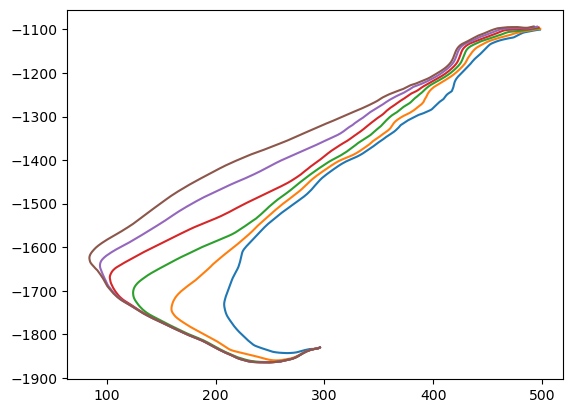

In [57]:
# Convert the flowline data from m to km
ziFlowlines['geometry_km'] = ziFlowlines['geometry'].apply(lambda geom: geom.xy)
ziFlowlines['geometry_km'] = ziFlowlines['geometry_km'].apply(lambda xy: (np.array(xy[0]) / 1000, np.array(xy[1]) / 1000))

# Plot the flowlines
for flowline_km in ziFlowlines['geometry_km']:
    plt.plot(flowline_km[0], flowline_km[1])

In [58]:
ziVelSeries

<xarray.Dataset> Size: 482MB
Dimensions:         (time: 443, band: 3, x: 301, y: 301)
Coordinates:
  * time            (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04...
    id              (time) <U115 204kB ...
  * band            (band) <U2 24B 'vx' 'vy' 'vv'
  * x               (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
  * y               (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06 -1.14e+06
    epsg            int64 8B ...
    name            <U4 16B ...
    time1           (time) datetime64[ns] 4kB ...
    time2           (time) datetime64[ns] 4kB ...
    _FillValue      float64 8B ...
Data variables:
    spatial_ref     int64 8B ...
    VelocitySeries  (time, band, y, x) float32 482MB ...

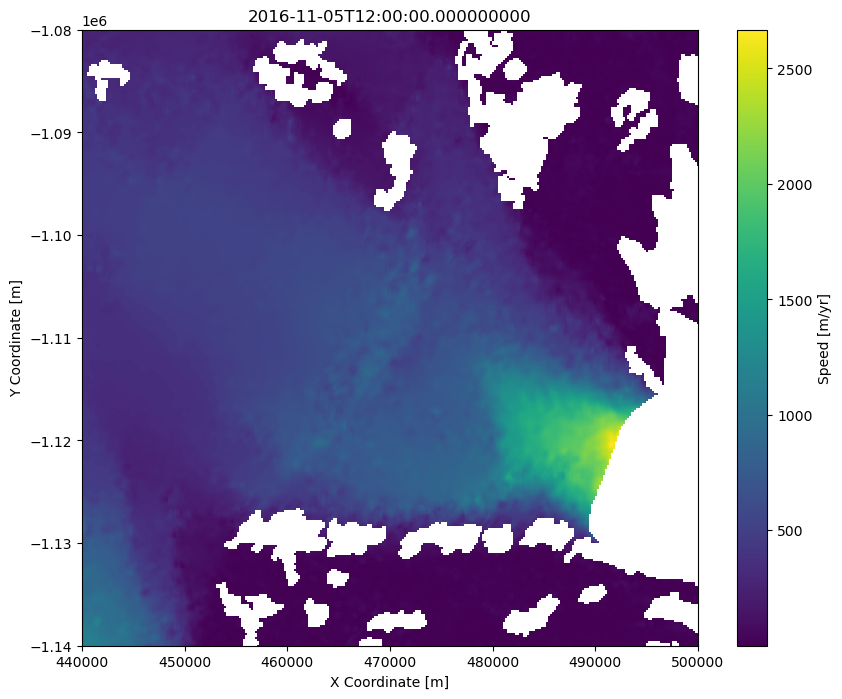

In [59]:
# Select the velocity values for a specific time and band
time_index = 59  # You can change this to select a different time index
band_index = 2  # You can change this to select a different band ('vx', 'vy', 'vv')
selected_time = ziVelSeries.time[time_index].values

velocity_values = ziVelSeries['VelocitySeries'].isel(time=time_index, band=band_index)

# Plot the velocity values
plt.figure(figsize=(10, 8))
plt.imshow(velocity_values, origin='lower', extent=[ziVelSeries.x.min(), 
                                                        ziVelSeries.x.max(), 
                                                        ziVelSeries.y.min(), 
                                                        ziVelSeries.y.max()])
plt.colorbar(label='Speed [m/yr]')
plt.xlabel('X Coordinate [m]')
plt.ylabel('Y Coordinate [m]')
plt.title('{}'.format(selected_time))
plt.show()

## 2. Convert linestrings to arrays of x and y points

Here we convert the flowlines to numpy arrays. Then, we select the flowline's (x, y) points from the overall dataset by interpolation and add these values to a new dataset. The new dataset, `combined_flowline_velocity_ds` contains the time series values for each flowline.

In [60]:
# Assuming `ziVelSeries` is the dataset with dimensions (time, x, y) 
# and `ziFlowlines.geometry` contains multiple flowlines

# Initialize a list to store the interpolated datasets for each flowline
flowline_datasets = []

# Loop over each flowline in ziFlowlines.geometry
for i, line in enumerate(iterable=ziFlowlines.geometry):
    # Extract x and y coordinates for the current flowline
    flowline_x = np.array([pt[0] for pt in ziFlowlines['geometry_km'][i]])
    flowline_y = np.array([pt[1] for pt in ziFlowlines['geometry_km'][i]])
        
    # Grab the value at the point on the flowline
    interpolated_velocity = ziVelSeries.sel(
        x=xr.DataArray(flowline_x, dims="points"),
        y=xr.DataArray(flowline_y, dims="points"),
        method="nearest"
    )["VelocitySeries"]

    # Create a new Dataset for the interpolated flowline data
    flowline_velocity_ds = xr.Dataset(
        {
            "velocity": interpolated_velocity
        },
        coords={
            "time": ziVelSeries.time,               # Time coordinates from original dataset
            "points": np.arange(len(flowline_x)),    # Index each point along the flowline
            "x": ("points", flowline_x),             # x-coordinates of each point
            "y": ("points", flowline_y)              # y-coordinates of each point
        },
        attrs={"flowline_id": i}  # Optional: add an attribute to label each flowline
    )
    
    # Append the dataset to the list
    flowline_datasets.append(flowline_velocity_ds)

# Combine all flowline datasets into a single xarray Dataset with a new "flowline" dimension
combined_flowline_velocity_ds = xr.concat(flowline_datasets, dim="flowline")

# Display the combined dataset structure
print(combined_flowline_velocity_ds)


<xarray.Dataset> Size: 278kB
Dimensions:     (time: 443, band: 3, flowline: 6, points: 2)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04-18T...
    id          (time) <U115 204kB 'https://n5eil01u.ecs.nsidc.org/DP4/MEASUR...
  * band        (band) <U2 24B 'vx' 'vy' 'vv'
    x           (flowline, points) float64 96B 497.8 -1.1e+03 ... -1.093e+03
    y           (flowline, points) float64 96B 497.6 -1.1e+03 ... -1.093e+03
    epsg        int64 8B 3413
    name        <U4 16B 'temp'
    time1       (time) datetime64[ns] 4kB 2015-01-01 2015-01-13 ... 2024-04-13
    time2       (time) datetime64[ns] 4kB 2015-01-12 2015-01-24 ... 2024-04-24
    _FillValue  float64 8B -1.0
  * points      (points) int64 16B 0 1
Dimensions without coordinates: flowline
Data variables:
    velocity    (flowline, time, band, points) float32 64kB 0.0 ... 1.186e+03
Attributes:
    flowline_id:  0


In [61]:
combined_flowline_velocity_ds.to_dataframe().reset_index()
combined_flowline_velocity_ds.to_dataframe().reset_index().to_csv('../data/clean/Combined_Flowline_Velocity.csv')